# Revised Universal Soil Loss Equation Notebook

## Introduction

Soil erosion poses a growing threat to global food security, with up to 40% of the world’s topsoil already degraded — a figure projected to rise to 90% by 2050 (UNCCD, 2022). As population growth intensifies land pressure, the ability to model and manage soil loss becomes critical. The Revised Universal Soil Loss Equation (RUSLE) is a widely adopted empirical model for estimating average annual soil erosion caused by rainfall and surface runoff.

This notebook implements a GIS-based RUSLE workflow in Python using open-source libraries. Each factor in the RUSLE equation is calculated separately and transparently:

```
A = R × K × LS × C × P
```

Where:
- *A* = annual soil loss (tonnes/hectare/year)
- *R* = rainfall erosivity
- *K* = soil erodibility
- *LS* = slope length and steepness
- *C* = cover management
- *P* = support practices

## Calculating R

The initial data for R comes from the Centre for Environmental Data Analysis (CEDA) (https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-daily-rain-obs), in this example rainfall point data data for the six counties Northern Ireland was used.

Interpolating with kriging...


Kriging rows: 100%|██████████| 138/138 [00:04<00:00, 30.23it/s]


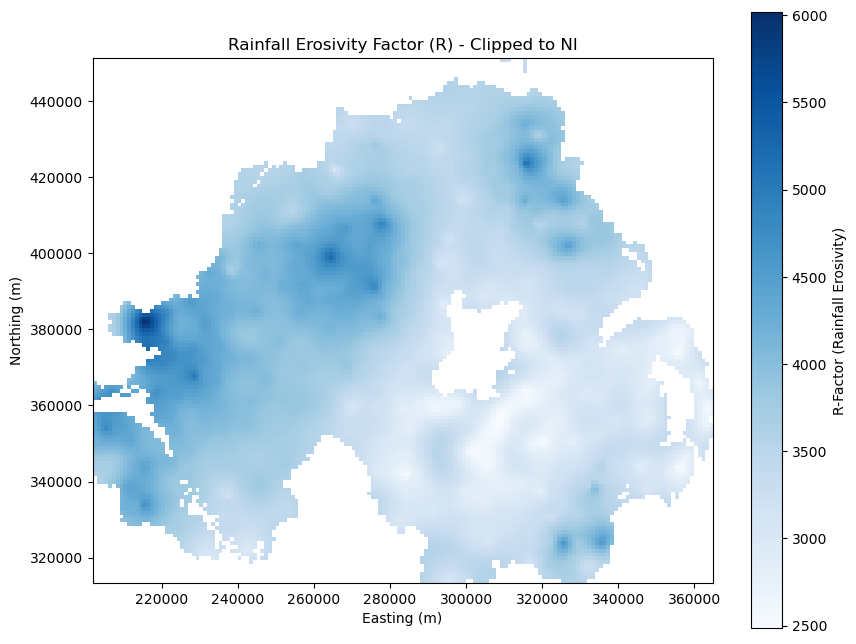

In [15]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from gstools import Krige, SRF, Spherical
import tqdm
import os
from rasterio.mask import mask
import matplotlib.pyplot as plt
from rasterio.plot import show

# Load and project point data
gdf = gpd.read_file(r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\R\NI_2021_Rain_Point.geojson")
gdf = gdf.to_crs(epsg=29903)

# Extract coords and rainfall
coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
values = gdf["RAINFALL"].values

# Create grid
grid_res = 1000
minx, miny, maxx, maxy = gdf.total_bounds
gridx = np.arange(minx, maxx + grid_res, grid_res)
gridy = np.arange(miny, maxy + grid_res, grid_res)
grid_xx, grid_yy = np.meshgrid(gridx, gridy)

# Define variogram model
model = Spherical(dim=2, len_scale=10000, var=np.var(values))

# Perform kriging with progress
krig = Krige(model, cond_pos=coords.T, cond_val=values)
print("Interpolating with kriging...")
field = np.full(grid_xx.shape, np.nan)

for i in tqdm.tqdm(range(len(gridy)), desc="Kriging rows"):
    row_x = grid_xx[i, :]
    row_y = grid_yy[i, :]
    points = np.vstack([row_x, row_y])
    field[i, :], _ = krig(points)

# Save to GeoTIFF
transform = from_origin(minx, maxy, grid_res, grid_res)
os.makedirs(r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\R", exist_ok=True)

rainfall_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\R\rainfall_gstools.tif"
with rasterio.open(
    rainfall_path,
    "w",
    driver="GTiff",
    height=field.shape[0],
    width=field.shape[1],
    count=1,
    dtype="float32",
    crs="EPSG:29903",
    transform=transform,
) as dst:
    dst.write(np.flipud(field), 1)

# Open the interpolated rainfall raster
with rasterio.open(rainfall_path) as src:
    rainfall = src.read(1)
    profile = src.profile

# Apply the R-factor equation
r_factor = 38.46 + (3.48 * rainfall)

# Update profile for output
profile.update(dtype=rasterio.float32)

# Save the R-factor raster
r_factor_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\R\r_factor.tif"
with rasterio.open(r_factor_path, "w", **profile) as dst:
    dst.write(r_factor.astype(np.float32), 1)

# Load NI outline polygon
ni_outline = gpd.read_file(r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\NI_Outline.geojson")
ni_outline = ni_outline.to_crs("EPSG:29903")

# Clip R-factor raster to Northern Ireland
with rasterio.open(r_factor_path) as src:
    out_image, out_transform = mask(src, ni_outline.geometry, crop=True)
    out_meta = src.meta.copy()

out_meta.update({
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

clipped_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\R\r_factor_clipped.tif"
with rasterio.open(clipped_path, "w", **out_meta) as dest:
    dest.write(out_image)

# Display the clipped raster
with rasterio.open(clipped_path) as src:
    r_factor_data = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Mask out zero values
masked_r = np.ma.masked_where(r_factor_data == 0, r_factor_data)

plt.figure(figsize=(10, 8))
plt.imshow(masked_r, cmap='Blues', extent=extent)
plt.colorbar(label="R-Factor (Rainfall Erosivity)")
plt.title("Rainfall Erosivity Factor (R) - Clipped to NI")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(False)
plt.show()


## Calculating K
The initial data for K comes from the European Soil Data Centre (ESDAC). The data contains percentages for silt, sand and clay as well as organic content. 
(https://esdac.jrc.ec.europa.eu/content/european-soil-database-derived-data). 

The files from ESDAC are converted to tiff files and then projected in ETRS89 / LAEA Europe projection (EPSG:3035)

Converted and assigned CRS: STU_EU_T_SILT.rst -> STU_EU_T_SILT.tif
Converted and assigned CRS: STU_EU_T_SAND.rst -> STU_EU_T_SAND.tif
Converted and assigned CRS: STU_EU_T_CLAY.rst -> STU_EU_T_CLAY.tif
Converted and assigned CRS: STU_EU_S_OC.rst -> STU_EU_S_OC.tif


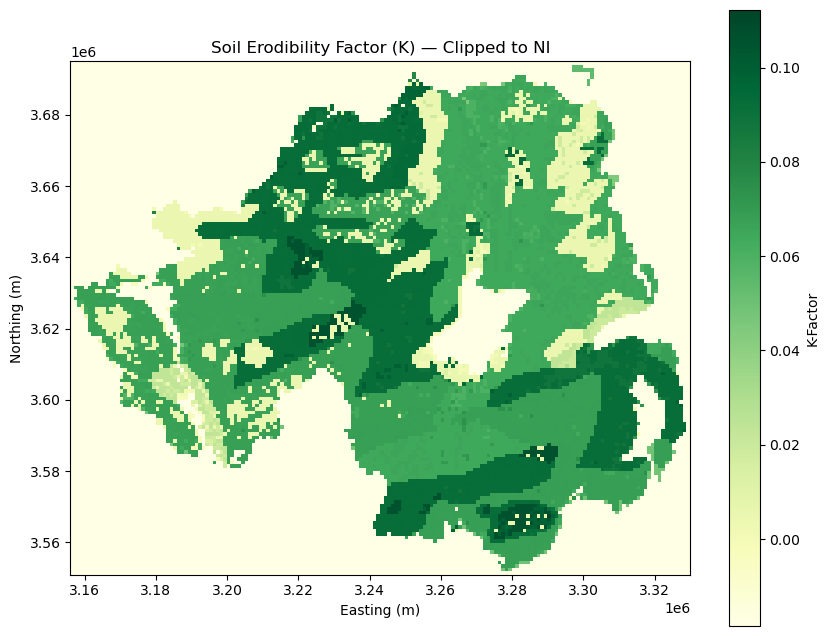

In [50]:
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os

# 1. Convert .rst to .tif with EPSG:3035
input_files = [
    "C:/GIS_Course/EGM721/Github conversion of RUSLE/RUSLE-in-Python/Data/K/STU_EU_T_SILT.rst",
    "C:/GIS_Course/EGM721/Github conversion of RUSLE/RUSLE-in-Python/Data/K/STU_EU_T_SAND.rst",
    "C:/GIS_Course/EGM721/Github conversion of RUSLE/RUSLE-in-Python/Data/K/STU_EU_T_CLAY.rst",
    "C:/GIS_Course/EGM721/Github conversion of RUSLE/RUSLE-in-Python/Data/K/STU_EU_S_OC.rst"
]
for rst_path in input_files:
    tif_path = rst_path.replace(".rst", ".tif")
    subprocess.run([
        "gdal_translate",
        "-a_srs", "EPSG:3035", 
        "-of", "GTiff",
        rst_path,
        tif_path
    ], check=True)
    print(f"Converted and assigned CRS: {os.path.basename(rst_path)} -> {os.path.basename(tif_path)}")

# 2. Define file paths for the clipped data
silt_path    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\STU_EU_T_SILT.tif"
sand_path    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\STU_EU_T_SAND.tif"
clay_path    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\STU_EU_T_CLAY.tif"
oc_path      = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\STU_EU_S_OC.tif"
texture_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\textureUSDA_eu23.tif"
mask_path    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\NI_Outline.geojson"

# Load Northern Ireland outline and reproject to EPSG:3035
ni_outline = gpd.read_file(mask_path).to_crs(epsg=3035)

# Helper to read + mask → returns (clipped_array, updated_profile)
def read_and_mask(path):
    with rasterio.open(path) as src:
        arr, out_transform = mask(src, ni_outline.geometry, crop=True)
        profile = src.profile.copy()
        profile.update({
            "height": arr.shape[1],
            "width": arr.shape[2],
            "transform": out_transform
        })
        return arr[0], profile

# 3. Clip each raster to Northern Ireland
silt, profile_silt       = read_and_mask(silt_path)
sand, _                  = read_and_mask(sand_path)
clay, _                  = read_and_mask(clay_path)
oc, _                    = read_and_mask(oc_path)
texture_clipped, profile_tex = read_and_mask(texture_path)

# 4. Reproject the clipped texture to exactly match the silt grid
texture_aligned = np.empty_like(silt, dtype=texture_clipped.dtype)
reproject(
    source=texture_clipped,
    destination=texture_aligned,
    src_transform=profile_tex["transform"],
    src_crs=profile_tex["crs"],
    dst_transform=profile_silt["transform"],
    dst_crs=profile_silt["crs"],
    resampling=Resampling.nearest
)

# 5. USDA lookups (soil structure & permeability)
structure_lookup = {
    1: 4, 2: 4, 3: 3, 4: 4, 5: 3, 6: 3, 
    7: 1, 8: 2, 9: 3, 10: 1, 11: 2, 12: 2
}

permeability_lookup = {
    1: 6, 2: 6, 3: 5, 4: 5, 5: 4, 6: 4,
    7: 3, 8: 3, 9: 2, 10: 1, 11: 1, 12: 2
}

structure_raster     = np.vectorize(lambda x: structure_lookup.get(x, 0))(texture_aligned)
permeability_raster  = np.vectorize(lambda x: permeability_lookup.get(x, 0))(texture_aligned)

# Save those two rasters (they now match the silt/clay/sand extent)
profile_uint8 = profile_silt.copy()
profile_uint8.update(dtype=rasterio.uint8)

structure_out = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\structure.tif"
permeability_out = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\permeability.tif"

with rasterio.open(structure_out, "w", **profile_uint8) as dst:
    dst.write(structure_raster.astype(np.uint8), 1)

with rasterio.open(permeability_out, "w", **profile_uint8) as dst:
    dst.write(permeability_raster.astype(np.uint8), 1)

# 6. Compute Soil Organic Matter (cap to 11%)
SOM = np.clip(oc * 1.724, None, 11)

# M–factor as (silt + sand) * (100 − clay)
M = (silt + sand) * (100 - clay)

# 7. Calculate K–factor with your exact formula
k_factor = (
    (2.1e-4) * (M ** 1.14) * (12 - SOM)
    + 3.25 * (structure_raster - 2)
    + 2.5 * (permeability_raster - 3)
) / 100 * 0.1317

# Save K–factor
profile_float32 = profile_silt.copy()
profile_float32.update(dtype=rasterio.float32)

k_factor_out = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\k_factor.tif"
with rasterio.open(k_factor_out, "w", **profile_float32) as dst:
    dst.write(k_factor.astype(np.float32), 1)

# Convert 0 values to NaN so they won’t plot
k_plot = k_factor.copy()
k_plot[k_plot == 0] = np.nan

plt.figure(figsize=(10, 8))
plt.imshow(
    k_plot,
    cmap="YlGn",  # Green = highest
    extent=[
        profile_silt["transform"][2],
        profile_silt["transform"][2] + profile_silt["transform"][0] * silt.shape[1],
        profile_silt["transform"][5] + profile_silt["transform"][4] * silt.shape[0],
        profile_silt["transform"][5]
    ]
)
plt.colorbar(label="K-Factor")
plt.title("Soil Erodibility Factor (K) — Clipped to NI")
plt.grid(False)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()

